In [58]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

In [2]:
mnist = fetch_openml('mnist_784', parser='auto', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (70000, 784)
y shape: (70000,)


### Example Digit

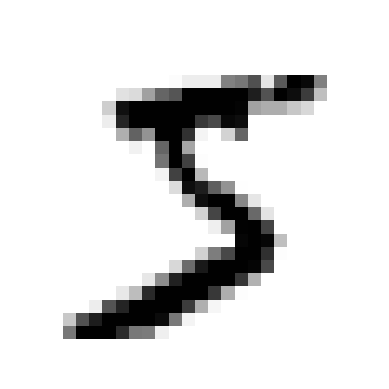

Targer of this digit is: ['5']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [5]:
some_digit = X[X.index == 0]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.savefig(r'data\example_digit.png', dpi=300)
plt.show()   
print(f"Targer of this digit is: {y[y.index == 0].values}")                                                                                                                                  

### Changing target column to numeric

In [6]:
y = y.astype(np.uint8)
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype
--------------  -----
70000 non-null  uint8
dtypes: uint8(1)
memory usage: 68.5 KB


### Train-test split
According to information about this dataset, I split dataset using indexes 

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [38]:
y_train_5.value_counts()/len(y_train_5)*100 # ---> PRECISION-RECAL PLOT to choose TRESHOLD (POSITIVE class is low)

False    90.965
True      9.035
Name: class, dtype: float64

### SGD CLassifier

In [9]:
sgd_clf = SGDClassifier(max_iter=1000, tol=0.001, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Confusion Matrix, Precission, Recall, F1 Score

In [11]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
print(f"Model is not wrong at {round(precision_score(y_train_5, y_train_pred)*100,2)}% |PRECISION")

Model is not wrong at 83.71% |PRECISION


In [14]:
print(f"Model recognize {round(recall_score(y_train_5, y_train_pred)*100,2)}% of target |RECALL")

Model recognize 65.12% of target |RECALL


In [15]:
f1_score(y_train_5, y_train_pred)                                                                                                                                                                      

0.7325171197343846

### Recal Curve

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [17]:
precisions, recalls, treshold = precision_recall_curve(y_train_5, y_scores)

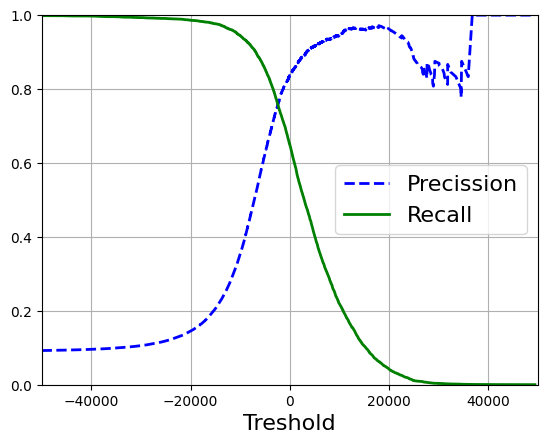

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precission", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Treshold", fontsize=16)             
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])   
plot_precision_recall_vs_threshold(precisions, recalls, treshold)          

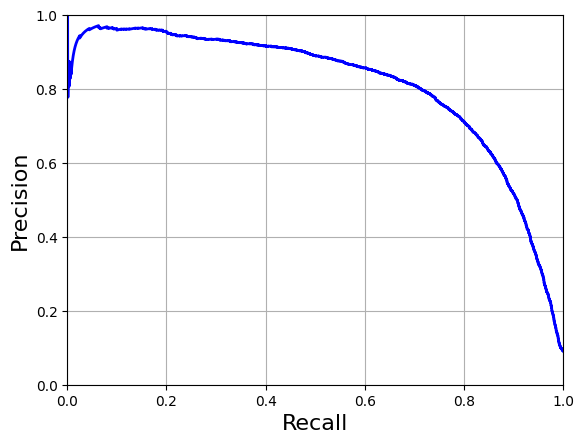

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
plot_precision_vs_recall(precisions, recalls)

In [24]:
treshold_80_precision = treshold[np.argmax(precisions >= 0.80)]
treshold_80_precision

-1328.41257665624

In [27]:
y_train_pred_80 = (y_scores > treshold_80_precision)
print(f"Model is not wrong at {round(precision_score(y_train_5, y_train_pred_80)*100,2)}% |PRECISION")
print(f"Model recognize {round(recall_score(y_train_5, y_train_pred_80)*100,2)}% of target |RECALL")

Model is not wrong at 80.0% |PRECISION
Model recognize 71.26% of target |RECALL


### ROC Curve

In [29]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

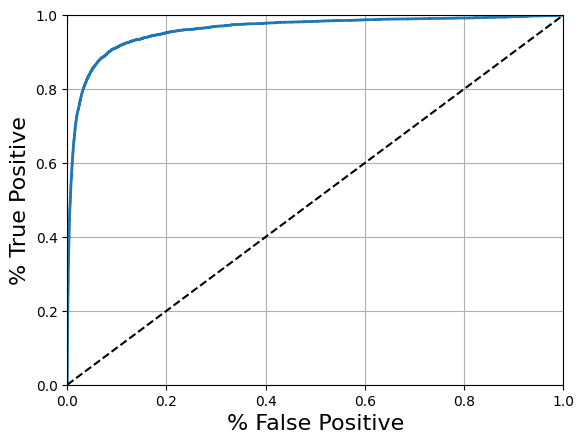

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                       
    plt.xlabel('% False Positive', fontsize=16)     
    plt.ylabel('% True Positive', fontsize=16)    
    plt.grid(True)                                               
plot_roc_curve(fpr, tpr)

In [39]:
print(f"AUC score = {roc_auc_score(y_train_5, y_scores)}") # still we should use PRECISION-RECALL plot to choose TRESHOLD

AUC score = 0.9604938554008616


### Random Forest Classifier

In [41]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [43]:
y_scores_forest = y_probas_forest[:, 1] # probability of belng to class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

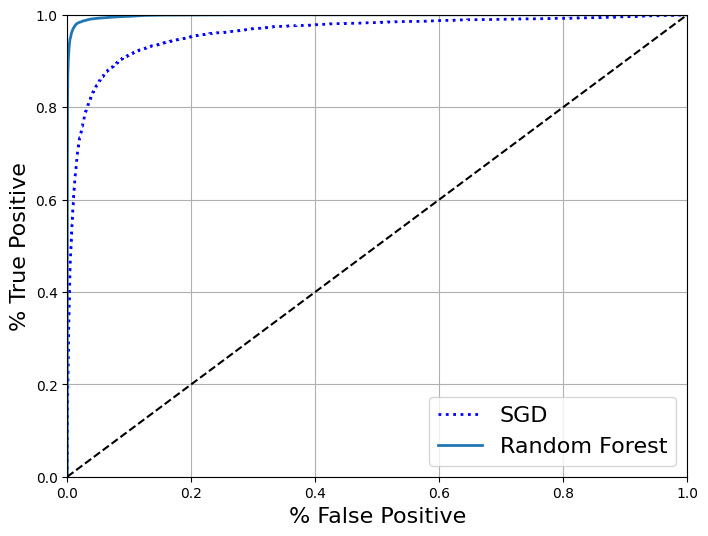

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [47]:
print(f"AUC score = {roc_auc_score(y_train_5,y_scores_forest)}") 

AUC score = 0.9983436731328145


In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(f"Model is not wrong at {round(precision_score(y_train_5,y_train_pred_forest)*100,2)}% |PRECISION")
print(f"Model recognize {round(recall_score(y_train_5,y_train_pred_forest)*100,2)}% of target |RECALL")

Model is not wrong at 99.05% |PRECISION
Model recognize 86.63% of target |RECALL


## Multiclass Classification

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

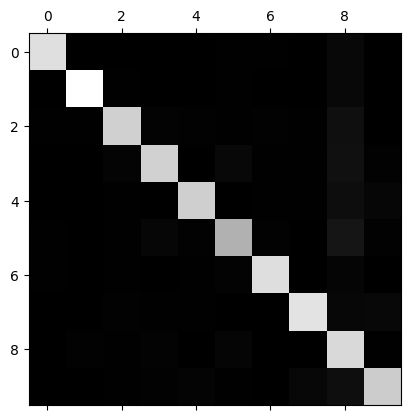

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### Looking to just errors

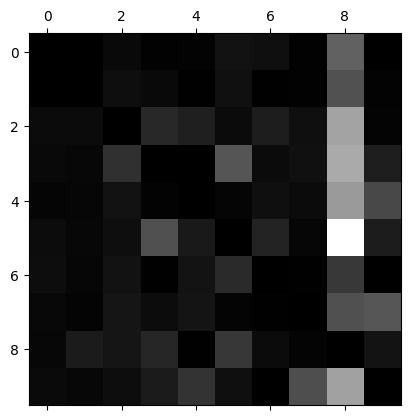

In [56]:
# rows -real_classes 
# cols -predicted_classes 
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
X_test_trained = scaler.transform(X_test.astype(np.float64))
cross_val_score(sgd_clf, X_test_trained, y_test, cv=3, scoring="accuracy")

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.86562687, 0.89888989, 0.89558956])

### Multi-label Classification

In [59]:
y_train_large_number = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large_number, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [64]:
y_train.values[0]

5

In [63]:
knn_clf.predict([X_train.values[0]])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [65]:
# code below is doing too long on my computer, execute it only on better computers or google colab etc

# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")